In [5]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 71.1 MB/s eta 0:00:00


In [6]:
# -*- coding: utf-8 -*-
"""PatchCore.ipynb

Implementation of PatchCore for Wood Anomaly Detection
"""

# Import necessary libraries
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import f1_score, roc_curve, auc, jaccard_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
import faiss

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the dataset paths
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'

Using device: cuda


In [8]:
class WoodDataset(Dataset):
    def __init__(self, image_paths, transform=None, grayscale=True):
        self.image_paths = image_paths
        self.transform = transform
        self.grayscale = grayscale

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        if self.grayscale:
            img = Image.open(img_path).convert('L')
            # Convert to 3-channel for pretrained models
            if self.transform:
                img = self.transform(img)
                img = torch.cat([img, img, img], dim=0)
        else:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)

        return img, img_path

In [9]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Helper function to load image paths
def get_image_paths(folder_path):
    return sorted(glob(os.path.join(folder_path, '*.jpg')))

# Get image paths
train_good_paths = get_image_paths(os.path.join(DATASET_DIR, 'train/good'))
test_good_paths = get_image_paths(os.path.join(DATASET_DIR, 'test/good'))
test_defect_paths = get_image_paths(os.path.join(DATASET_DIR, 'test/defect'))
mask_defect_paths = get_image_paths(os.path.join(DATASET_DIR, 'ground_truth/defect'))

# Create datasets
train_dataset = WoodDataset(train_good_paths, transform=transform, grayscale=True)
test_good_dataset = WoodDataset(test_good_paths, transform=transform, grayscale=True)
test_defect_dataset = WoodDataset(test_defect_paths, transform=transform, grayscale=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_good_loader = DataLoader(test_good_dataset, batch_size=32, shuffle=False)
test_defect_loader = DataLoader(test_defect_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Train samples: {len(train_dataset)}")
print(f"Test good samples: {len(test_good_dataset)}")
print(f"Test defect samples: {len(test_defect_dataset)}")

class FeatureExtractor(torch.nn.Module):
    """
    Feature extractor for PatchCore using pretrained CNN.
    Extracts features from multiple layers to capture multi-scale information.
    """
    def __init__(self, backbone='wide_resnet50_2'):
        super(FeatureExtractor, self).__init__()

        # Load the pretrained model
        if backbone == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            # Modify first conv for grayscale input (1 channel to 3)
            self.model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            # Feature layers to extract from
            self.feature_layers = ['layer2', 'layer3']
            self.output_dims = {
                'layer2': 128,
                'layer3': 256
            }
        elif backbone == 'wide_resnet50_2':
            self.model = models.wide_resnet50_2(pretrained=True)
            self.model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.feature_layers = ['layer2', 'layer3']
            self.output_dims = {
                'layer2': 512,
                'layer3': 1024
            }
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Set model to evaluation mode
        self.model.eval()

        # Calculate total dimension of concatenated features
        self.total_dim = sum(self.output_dims.values())

    def forward(self, x):
        """
        Extract features from multiple layers

        Args:
            x: Input image batch

        Returns:
            Dictionary of features from each specified layer
        """
        features = {}

        # Initial layers
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        # Layer 1
        x = self.model.layer1(x)

        # Extract from specified layers
        x = self.model.layer2(x)
        features['layer2'] = x

        x = self.model.layer3(x)
        features['layer3'] = x

        return features

class PatchCore:
    """
    PatchCore for anomaly detection:
    1. Extract patch features from normal samples
    2. Create a memory bank of features using coreset sampling
    3. Detect anomalies using nearest neighbor search
    """
    def __init__(self, backbone='wide_resnet50_2', num_neighbors=1, coreset_ratio=0.1):
        """
        Initialize PatchCore model

        Args:
            backbone: CNN backbone for feature extraction
            num_neighbors: Number of nearest neighbors to use for anomaly scoring
            coreset_ratio: Ratio of features to keep after coreset sampling
        """
        self.backbone = backbone
        self.num_neighbors = num_neighbors
        self.coreset_ratio = coreset_ratio

        # Feature extractor
        self.feature_extractor = FeatureExtractor(backbone).to(device)

        # Memory bank for normal patch features
        self.memory_bank = None

        # FAISS index for fast nearest neighbor lookup
        self.index = None

        # Feature dimensions
        self.total_dim = self.feature_extractor.total_dim
        self.patch_shape = None

    def _extract_features(self, data_loader):
        """
        Extract patch features from all images

        Args:
            data_loader: DataLoader for the dataset

        Returns:
            patch_features: Concatenated patch features from all images
            filenames: List of image filenames
        """
        self.feature_extractor.eval()
        patch_features = []
        filenames = []

        with torch.no_grad():
            for imgs, paths in tqdm(data_loader, desc="Extracting features"):
                imgs = imgs.to(device)
                # Get features from multiple layers
                features_dict = self.feature_extractor(imgs)

                # Process and concatenate features from different layers
                batch_features = []

                for layer_name in self.feature_extractor.feature_layers:
                    layer_features = features_dict[layer_name]

                    # For the first batch, store the patch shape
                    if self.patch_shape is None:
                        self.patch_shape = layer_features.shape[2:]

                    # Adjust feature map sizes if necessary (interpolation)
                    if layer_features.shape[2:] != self.patch_shape:
                        layer_features = torch.nn.functional.interpolate(
                            layer_features,
                            size=self.patch_shape,
                            mode='bilinear'
                        )

                    # Reshape to [B, C, H*W]
                    b, c, h, w = layer_features.shape
                    layer_features = layer_features.reshape(b, c, h*w)

                    # Transpose to [B, H*W, C]
                    layer_features = layer_features.transpose(1, 2)

                    batch_features.append(layer_features)

                # Concatenate features from all layers along feature dimension
                # Shape: [B, H*W, total_dim]
                concatenated_features = torch.cat(batch_features, dim=2)

                # Reshape to [B*H*W, total_dim]
                concatenated_features = concatenated_features.reshape(-1, self.total_dim)

                patch_features.append(concatenated_features.cpu())
                filenames.extend(paths)

        # Concatenate all patch features
        patch_features = torch.cat(patch_features, dim=0)

        return patch_features, filenames

    def _greedy_coreset_sampling(self, features, coreset_size):
        """
        Reduce feature bank size using greedy coreset sampling

        Args:
            features: All features to sample from [N, D]
            coreset_size: Target size of the coreset

        Returns:
            indices: Indices of selected features
        """
        print(f"Performing coreset sampling: {features.shape[0]} -> {coreset_size}")

        # Convert to numpy for sampling
        features_np = features.numpy()

        # Initialize with a random feature
        selected_indices = [random.randint(0, features_np.shape[0]-1)]
        selected_features = features_np[selected_indices]

        # Compute minimum distances
        min_distances = np.min(cdist(features_np, selected_features), axis=1)

        # Greedy selection
        for _ in tqdm(range(coreset_size - 1), desc="Coreset sampling"):
            # Select the point with maximum minimum distance
            new_idx = np.argmax(min_distances)
            selected_indices.append(new_idx)
            selected_features = features_np[selected_indices]

            # Update minimum distances
            new_distances = cdist(features_np, selected_features[[len(selected_indices)-1]])
            min_distances = np.minimum(min_distances, new_distances.flatten())

        print(f"Coreset sampling completed: {len(selected_indices)} features selected")
        return selected_indices

    def fit(self, train_loader):
        """
        Build memory bank from normal samples

        Args:
            train_loader: DataLoader with normal samples for training
        """
        # Extract features from normal training data
        patch_features, _ = self._extract_features(train_loader)

        # Calculate coreset size
        coreset_size = max(1, int(self.coreset_ratio * patch_features.shape[0]))

        # Perform coreset sampling if necessary
        if coreset_size < patch_features.shape[0]:
            selected_indices = self._greedy_coreset_sampling(patch_features, coreset_size)
            self.memory_bank = patch_features[selected_indices]
        else:
            self.memory_bank = patch_features

        print(f"Memory bank size: {self.memory_bank.shape}")

        # Create FAISS index for fast nearest neighbor search
        memory_bank_np = self.memory_bank.numpy().astype('float32')

        # Use L2 distance for feature comparison
        self.index = faiss.IndexFlatL2(self.total_dim)
        # Add vectors to the index
        self.index.add(memory_bank_np)

        print("PatchCore model fitting completed")
        return self

    def predict(self, test_loader):
        """
        Detect anomalies using nearest neighbor search

        Args:
            test_loader: DataLoader with test samples

        Returns:
            Dictionary with anomaly scores and score maps
        """
        # Extract features from test data
        patch_features, filenames = self._extract_features(test_loader)

        # Convert to numpy for FAISS
        patch_features_np = patch_features.numpy().astype('float32')

        # Calculate the number of patches per image
        num_images = len(filenames)
        h, w = self.patch_shape
        patches_per_image = h * w

        # Perform nearest neighbor search
        k = min(self.num_neighbors, self.memory_bank.shape[0])
        distances, _ = self.index.search(patch_features_np, k)

        # Average the distances of k-nearest neighbors
        patch_distances = distances.mean(axis=1)

        # Reshape distances to image format
        score_maps = patch_distances.reshape(num_images, h, w)

        # Apply Gaussian smoothing for better visualization
        smoothed_score_maps = np.zeros_like(score_maps)
        for i in range(num_images):
            smoothed_score_maps[i] = gaussian_filter(score_maps[i], sigma=4)

        # Calculate image-level scores (max of patch scores)
        img_scores = smoothed_score_maps.reshape(num_images, -1).max(axis=1)

        # Load the images for visualization
        test_imgs = []
        for batch, _ in test_loader:
            test_imgs.extend(batch.cpu())

        return {
            "scores": img_scores,
            "score_maps": smoothed_score_maps,
            "images": test_imgs,
            "filenames": filenames
        }

# Initialize PatchCore model
patchcore = PatchCore(
    backbone='resnet18',
    # wide_resnet50_2 da çok ağır geliyodu ama coresset_ratio düşürerek eğitme zamanını yarıya çektik
    # resnet18 denedim o da çok hafif geldi
    # Yine de resnet18 devam
    num_neighbors=9,
    coreset_ratio=0.05  # Burasi 0.1 idi
)

Train samples: 70
Test good samples: 70
Test defect samples: 71


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [10]:
# Fit the model on normal samples
patchcore.fit(train_loader)

Extracting features: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Performing coreset sampling: 71680 -> 3584


Coreset sampling: 100%|██████████| 3583/3583 [06:56<00:00,  8.60it/s]

Coreset sampling completed: 3584 features selected
Memory bank size: torch.Size([3584, 384])
PatchCore model fitting completed


In [11]:
# Predict on test samples
print("Evaluating on normal test samples...")
test_good_results = patchcore.predict(test_good_loader)

Evaluating on normal test samples...


Extracting features: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


In [12]:
print("Evaluating on defect test samples...")
test_defect_results = patchcore.predict(test_defect_loader)

Evaluating on defect test samples...


Extracting features: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


In [13]:
# Combine results for evaluation
all_scores = np.concatenate([test_good_results["scores"], test_defect_results["scores"]])
all_maps = np.concatenate([test_good_results["score_maps"], test_defect_results["score_maps"]])
all_imgs = test_good_results["images"] + test_defect_results["images"]

# Ground truth labels (0 for normal, 1 for anomaly)
y_true = np.array([0] * len(test_good_results["scores"]) + [1] * len(test_defect_results["scores"]))

# Calculate ROC curve and optimal threshold
fpr, tpr, thresholds = roc_curve(y_true, all_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Generate predictions based on the optimal threshold
y_pred = (all_scores > optimal_threshold).astype(int)

# Calculate F1 score and ROC AUC
f1 = f1_score(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Optimal threshold: 3.5965
F1 Score: 0.8175
ROC AUC: 0.8592


In [14]:
# Calculate scores statistics for good and defect samples
good_scores = test_good_results["scores"]
defect_scores = test_defect_results["scores"]

print(f"Good samples - Mean score: {np.mean(good_scores):.4f}, Max: {np.max(good_scores):.4f}, Min: {np.min(good_scores):.4f}")
print(f"Defect samples - Mean score: {np.mean(defect_scores):.4f}, Max: {np.max(defect_scores):.4f}, Min: {np.min(defect_scores):.4f}")

Good samples - Mean score: 3.2869, Max: 14.7390, Min: 2.0471
Defect samples - Mean score: 5.4005, Max: 18.8601, Min: 2.4175


In [15]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve with AUC."""
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_score_distributions(good_scores, defect_scores, threshold=None):
    """Plot distribution of anomaly scores for normal and anomalous samples."""
    plt.figure(figsize=(10, 6))
    plt.hist(good_scores, bins=30, alpha=0.5, label='Normal Samples', color='green')
    plt.hist(defect_scores, bins=30, alpha=0.5, label='Anomaly Samples', color='red')

    if threshold is not None:
        plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.show()

In [16]:
def visualize_anomaly_detection(images, score_maps, scores, threshold, num_samples=5,
                                indices=None, cmap='viridis'):
    """
    Visualize anomaly detection results with original image, heatmap, and overlay.

    Args:
        images: List of test images
        score_maps: Array of anomaly score maps
        scores: Array of anomaly scores
        threshold: Threshold for anomaly detection
        num_samples: Number of samples to visualize
        indices: Optional specific indices to visualize
        cmap: Colormap for heatmap visualization
    """
    if indices is None:
        indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)

    plt.figure(figsize=(15, 3*len(indices)))

    for i, idx in enumerate(indices):
        # Get the image
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        # For grayscale (3 identical channels), take first channel
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]

        # Denormalize the image for better visualization
        img = (img - img.min()) / (img.max() - img.min())

        # Get score map and normalize
        score_map = score_maps[idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Resize score map to match image size if needed
        if score_map_norm.shape != img.shape[:2]:
            score_map_resized = cv2.resize(score_map_norm, (img.shape[1], img.shape[0]))
        else:
            score_map_resized = score_map_norm

        # Binary mask using threshold
        binary_mask = (score_map_resized > threshold).astype(float)

        is_anomaly = scores[idx] > threshold

        # Plot original image
        plt.subplot(len(indices), 3, 3*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{'Anomaly' if is_anomaly else 'Normal'} - Score: {scores[idx]:.4f}")
        plt.axis('off')

        # Plot heatmap
        plt.subplot(len(indices), 3, 3*i + 2)
        plt.imshow(score_map_resized, cmap=cmap)
        plt.title('Anomaly Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        # Plot overlay
        plt.subplot(len(indices), 3, 3*i + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(score_map_resized, cmap=cmap, alpha=0.5)
        plt.title('Anomaly Overlay')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

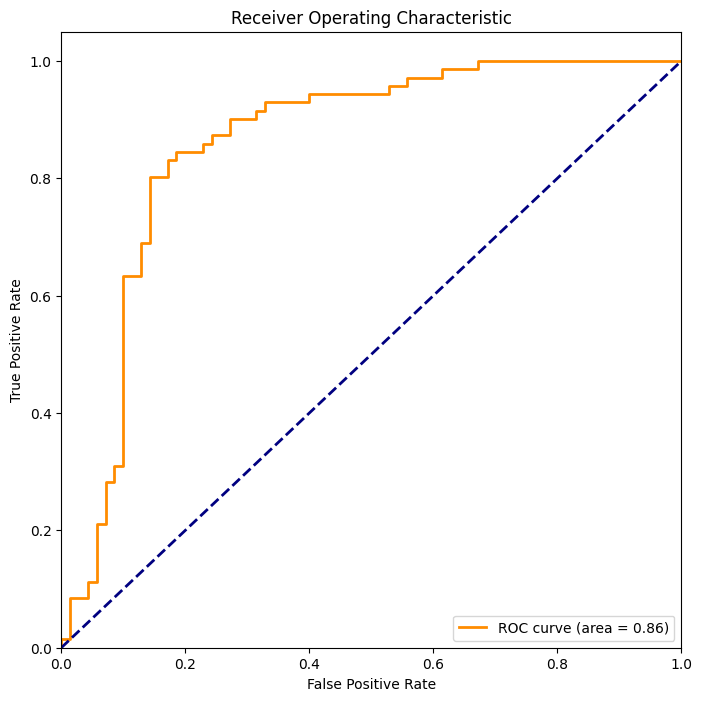

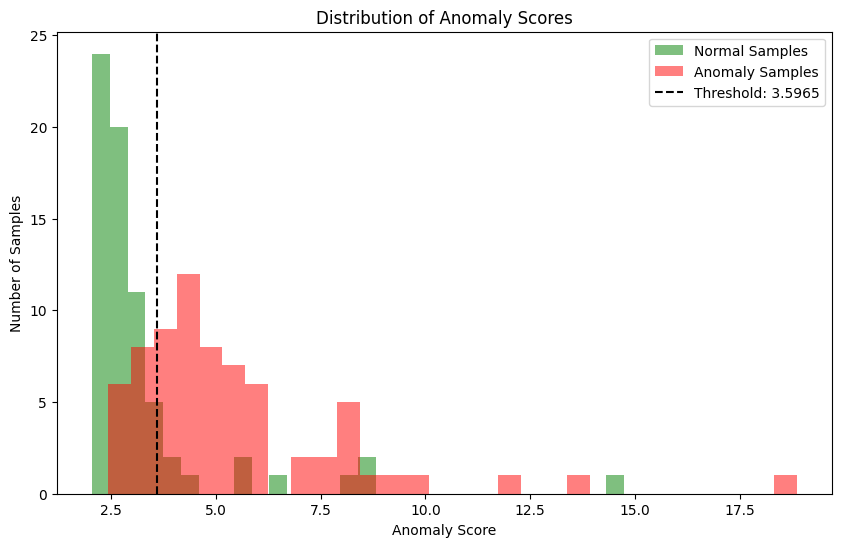

Normal samples visualization:


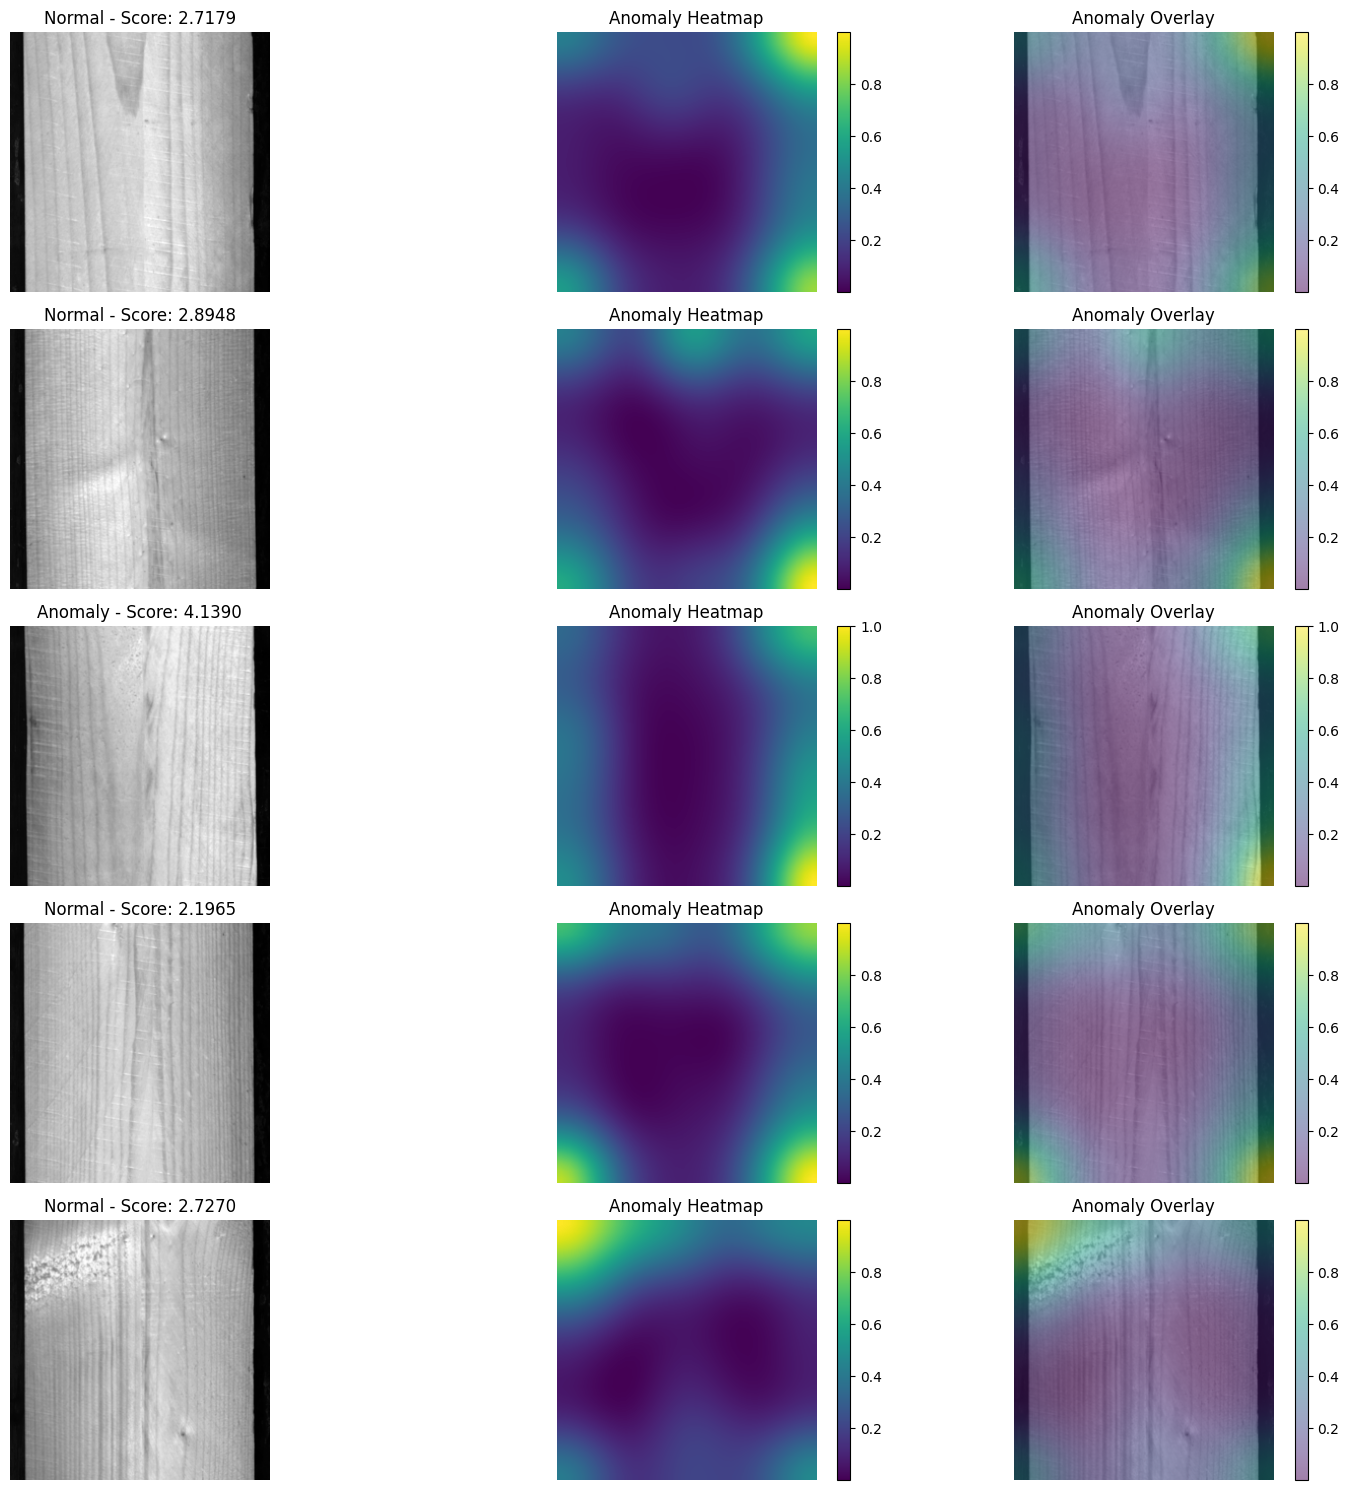

Anomaly samples visualization:


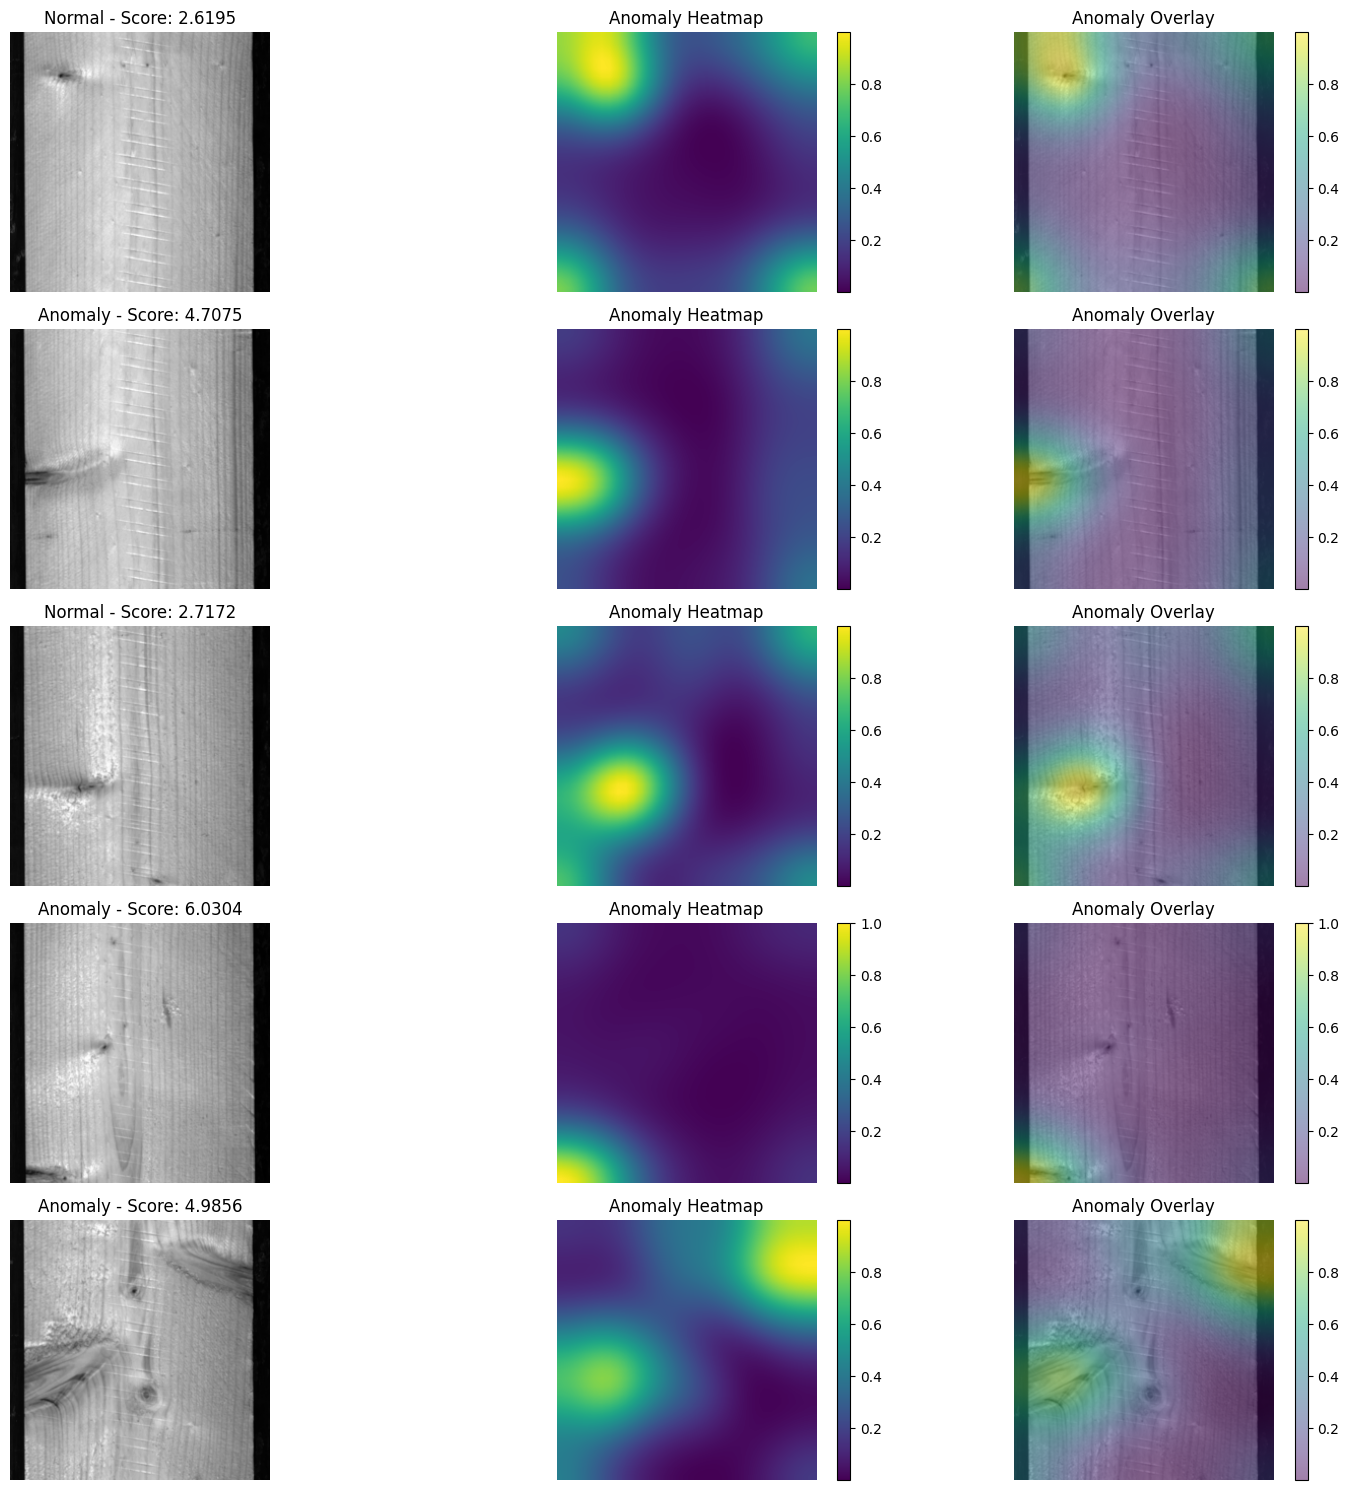

In [17]:
def visualize_segmentation_results(images, score_maps, scores, mask_paths, threshold, indices=None, num_samples=5):
    """
    Visualize segmentation results compared with ground truth masks.

    Args:
        images: List of test images
        score_maps: Array of anomaly score maps
        scores: Array of anomaly scores
        mask_paths: List of paths to ground truth masks
        threshold: Threshold for binary anomaly detection
        indices: Optional list of specific indices to visualize
        num_samples: Number of samples to visualize if indices is None
    """
    # Load ground truth masks
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)  # Binarize
        masks.append(mask)

    if indices is None:
        # Choose from defect samples only (assuming they're at the end of the list)
        start_idx = len(images) - len(masks)
        indices = np.random.choice(len(masks), size=min(num_samples, len(masks)), replace=False)
        indices = [start_idx + idx for idx in indices]  # Adjust indices to point to defect samples

    plt.figure(figsize=(16, 4*len(indices)))

    for i, idx in enumerate(indices):
        # Get image
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        # Get score map
        score_map = score_maps[idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Resize score map to match image size if needed
        if score_map_norm.shape != img.shape[:2]:
            score_map_resized = cv2.resize(score_map_norm, (img.shape[1], img.shape[0]))
        else:
            score_map_resized = score_map_norm

        # Binary prediction mask
        pred_mask = (score_map_resized > threshold).astype(np.float32)

        # Get corresponding ground truth mask
        mask_idx = idx - (len(images) - len(masks))
        if 0 <= mask_idx < len(masks):
            gt_mask = masks[mask_idx]
        else:
            # Create empty mask if no ground truth available
            gt_mask = np.zeros_like(img)

        # Plot results
        plt.subplot(len(indices), 4, 4*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Anomaly - Score: {scores[idx]:.4f}")
        plt.axis('off')

        plt.subplot(len(indices), 4, 4*i + 2)
        plt.imshow(score_map_resized, cmap='jet')
        plt.title('Anomaly Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        plt.subplot(len(indices), 4, 4*i + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_mask, cmap='OrRd', alpha=0.5)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(len(indices), 4, 4*i + 4)
        plt.imshow(img, cmap='gray')
        plt.imshow(gt_mask, cmap='OrRd', alpha=0.5)
        plt.title('Ground Truth')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

# Visualize score distributions
plot_score_distributions(good_scores, defect_scores, threshold=optimal_threshold)

# Visualize normal samples
print("Normal samples visualization:")
normal_indices = np.random.choice(len(test_good_results["scores"]),
                                 size=min(5, len(test_good_results["scores"])),
                                 replace=False)
visualize_anomaly_detection(
    test_good_results["images"],
    test_good_results["score_maps"],
    test_good_results["scores"],
    threshold=optimal_threshold,
    indices=normal_indices
)

# Visualize anomaly samples
print("Anomaly samples visualization:")
anomaly_indices = np.random.choice(len(test_defect_results["scores"]),
                                  size=min(5, len(test_defect_results["scores"])),
                                  replace=False)
visualize_anomaly_detection(
    test_defect_results["images"],
    test_defect_results["score_maps"],
    test_defect_results["scores"],
    threshold=optimal_threshold,
    indices=anomaly_indices
)

# Calculate IoU for the anomaly segmentation

# Pixel-level threshold for anomaly maps (may need tuning)
pixel_threshold = np.percentile(
    np.concatenate([score_map.flatten() for score_map in test_defect_results["score_maps"]]),
    80
)

Mean IoU: 0.0000


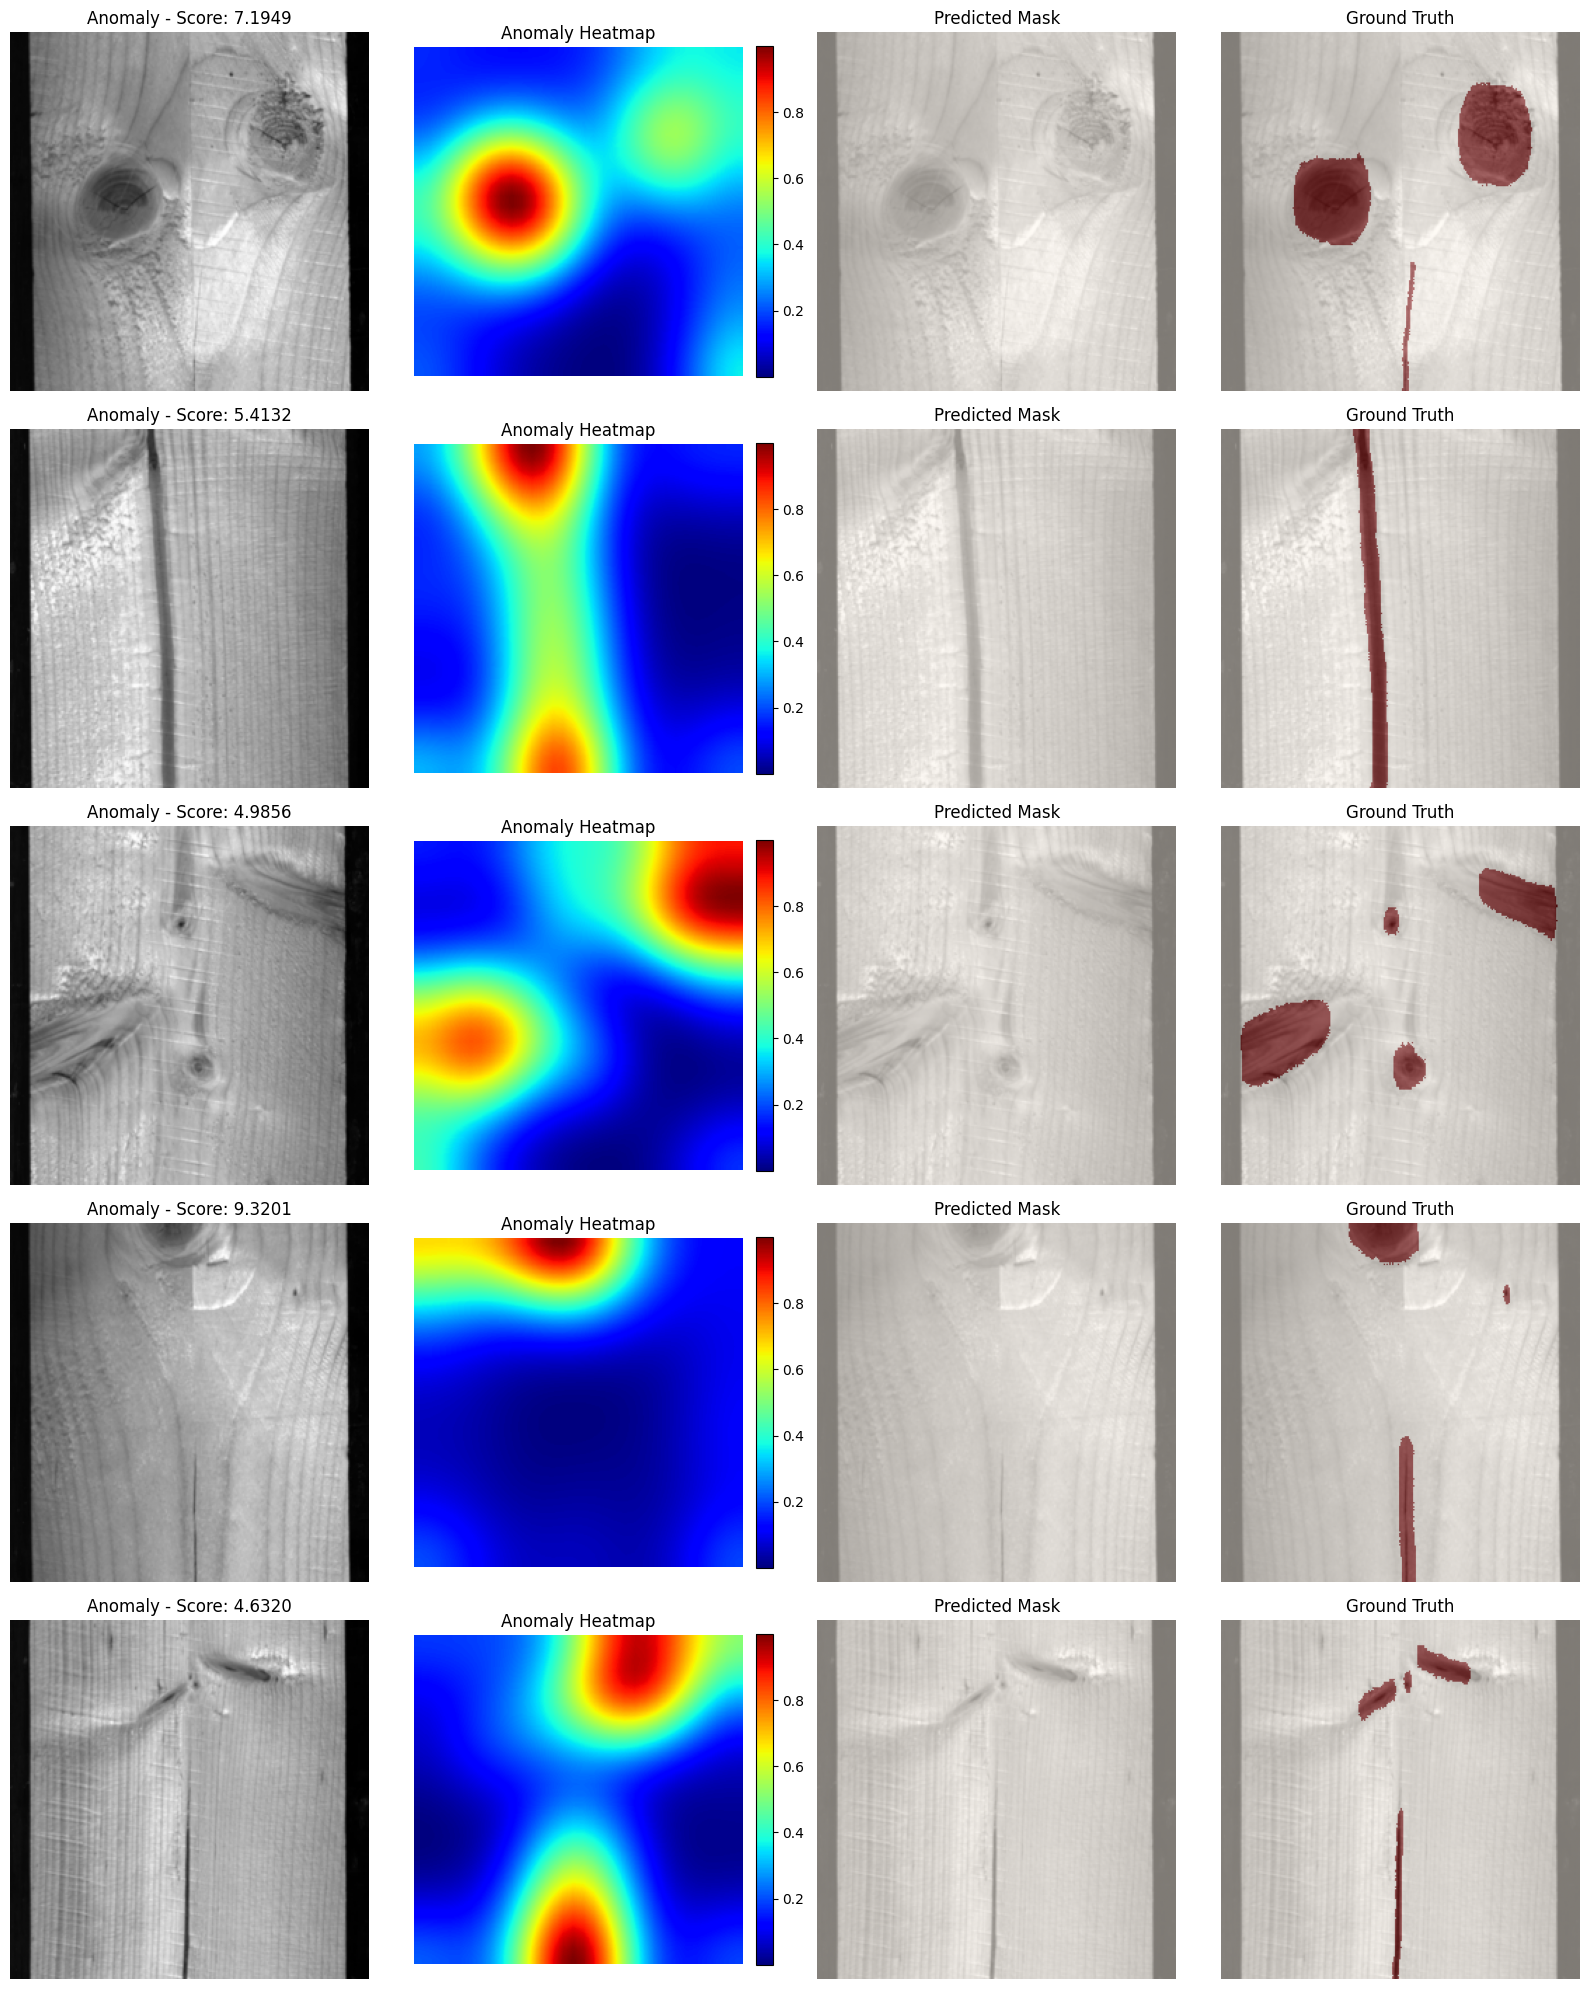

Model saved to /content/drive/MyDrive/wood_dataset/patchcore_model.pkl
PatchCore evaluation completed!


In [18]:
# Load ground truth masks
def load_masks(mask_paths, size=(256, 256)):
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        mask = (mask > 0).astype(np.float32)  # Binarize
        masks.append(mask)
    return masks

ground_truth_masks = load_masks(mask_defect_paths)

# Calculate IoU for defect samples
ious = []
for i, score_map in enumerate(test_defect_results["score_maps"]):
    if i < len(ground_truth_masks):
        # Resize score map to match ground truth dimensions if needed
        if score_map.shape != (256, 256):
            score_map_resized = cv2.resize(score_map, (256, 256))
        else:
            score_map_resized = score_map

        # Normalize score map
        score_map_norm = (score_map_resized - score_map_resized.min()) / (score_map_resized.max() - score_map_resized.min() + 1e-7)

        # Create binary prediction mask
        pred_mask = (score_map_norm > pixel_threshold).astype(np.uint8)

        # Get ground truth mask
        gt_mask = ground_truth_masks[i].astype(np.uint8)

        # Calculate IoU
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        union = np.logical_or(pred_mask, gt_mask).sum()
        iou = intersection / (union + 1e-10)  # Add small epsilon to avoid division by zero
        ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Visualize segmentation results
visualize_segmentation_results(
    test_defect_results["images"],
    test_defect_results["score_maps"],
    test_defect_results["scores"],
    mask_defect_paths,
    threshold=pixel_threshold,
    num_samples=5
)

# Experiment with different parameters of PatchCore
def tune_patchcore_params(train_loader, test_good_loader, test_defect_loader):
    """
    Experiment with different hyperparameters for PatchCore

    Args:
        train_loader: DataLoader with normal training samples
        test_good_loader: DataLoader with normal test samples
        test_defect_loader: DataLoader with anomaly test samples

    Returns:
        Dictionary with performance metrics for each configuration
    """
    configurations = [
        {'backbone': 'wide_resnet50_2', 'num_neighbors': 1, 'coreset_ratio': 0.1},
        {'backbone': 'wide_resnet50_2', 'num_neighbors': 5, 'coreset_ratio': 0.1},
        {'backbone': 'wide_resnet50_2', 'num_neighbors': 9, 'coreset_ratio': 0.1},
        {'backbone': 'resnet18', 'num_neighbors': 9, 'coreset_ratio': 0.1},
    ]

    results = []

    for config in configurations:
        print(f"\nEvaluating PatchCore with {config}")

        model = PatchCore(
            backbone=config['backbone'],
            num_neighbors=config['num_neighbors'],
            coreset_ratio=config['coreset_ratio']
        )

        # Fit the model
        model.fit(train_loader)

        # Evaluate on test sets
        test_good_results = model.predict(test_good_loader)
        test_defect_results = model.predict(test_defect_loader)

        # Combine results for evaluation
        all_scores = np.concatenate([test_good_results["scores"], test_defect_results["scores"]])
        y_true = np.array([0] * len(test_good_results["scores"]) + [1] * len(test_defect_results["scores"]))

        # Calculate metrics
        fpr, tpr, thresholds = roc_curve(y_true, all_scores)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        # Predictions using optimal threshold
        y_pred = (all_scores > optimal_threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        config_result = {
            'config': config,
            'f1': f1,
            'roc_auc': roc_auc,
            'threshold': optimal_threshold
        }
        results.append(config_result)

    return results

# Run hyperparameter tuning (optional, comment out if you want to skip)
# tuning_results = tune_patchcore_params(train_loader, test_good_loader, test_defect_loader)

# Save the PatchCore model
import pickle

def save_patchcore_model(model, filepath):
    """
    Save the trained PatchCore model

    Args:
        model: Trained PatchCore model
        filepath: Path to save the model
    """
    # Create a dictionary with model components (excluding FAISS index which is not directly serializable)
    memory_bank_np = model.memory_bank.numpy() if isinstance(model.memory_bank, torch.Tensor) else model.memory_bank

    model_dict = {
        "memory_bank": memory_bank_np,
        "total_dim": model.total_dim,
        "patch_shape": model.patch_shape,
        "backbone": model.backbone,
        "num_neighbors": model.num_neighbors
    }

    # Save to disk
    with open(filepath, 'wb') as f:
        pickle.dump(model_dict, f)

    print(f"Model saved to {filepath}")

# Save the trained model
save_path = "/content/drive/MyDrive/wood_dataset/patchcore_model.pkl"
save_patchcore_model(patchcore, save_path)

# Compare with PADIM and EfficientAD (if models are available)
def compare_models(results):
    """
    Compare results of different models

    Args:
        results: Dictionary with results from different models
    """
    models = list(results.keys())
    metrics = ['f1', 'roc_auc', 'iou']

    # Prepare data for plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.2
    multiplier = 0

    for model_name, model_results in results.items():
        offset = width * multiplier
        ax.bar(x + offset, [model_results[metric] for metric in metrics], width, label=model_name)
        multiplier += 1

    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison')
    ax.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# If you want to compare models, uncomment the following code and provide results
# comparison_results = {
#     'PADIM': {'f1': 0.95, 'roc_auc': 0.98, 'iou': 0.72},
#     'EfficientAD': {'f1': 0.92, 'roc_auc': 0.97, 'iou': 0.68},
#     'PatchCore': {'f1': f1, 'roc_auc': roc_auc, 'iou': mean_iou}
# }
# compare_models(comparison_results)

print("PatchCore evaluation completed!")

In [19]:
# Save the trained model
save_path = "/content/drive/MyDrive/wood_dataset/patchcore_model.pkl"
save_patchcore_model(patchcore, save_path)

Model saved to /content/drive/MyDrive/wood_dataset/patchcore_model.pkl


In [20]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# Function to generate HTML report for PatchCore results
def create_html_report(test_good_results, test_defect_results, optimal_threshold, f1, roc_auc, fpr, tpr, mean_iou, save_path):
    """
    Create a comprehensive HTML report with PatchCore results

    Args:
        test_good_results: Results dictionary for normal test samples
        test_defect_results: Results dictionary for defect test samples
        optimal_threshold: Optimal threshold for anomaly detection
        f1: F1 score
        roc_auc: ROC AUC score
        fpr: False positive rates for ROC curve
        tpr: True positive rates for ROC curve
        mean_iou: Mean IoU for segmentation
        save_path: Path to save the HTML report
    """
    # Combine scores from good and defect samples
    good_scores = test_good_results["scores"]
    defect_scores = test_defect_results["scores"]
    all_scores = np.concatenate([good_scores, defect_scores])

    # Get true labels and predictions
    true_labels = np.array([0] * len(good_scores) + [1] * len(defect_scores))
    predictions = (all_scores > optimal_threshold).astype(int)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Image_Index': range(len(all_scores)),
        'True_Label': ['Good' if label == 0 else 'Defect' for label in true_labels],
        'Predicted_Label': ['Good' if pred == 0 else 'Defect' for pred in predictions],
        'Anomaly_Score': all_scores,
        'Is_Correct': true_labels == predictions
    })

    # Calculate performance metrics
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions,
                                        target_names=['Good', 'Defect'],
                                        output_dict=True)

    # Generate confusion matrix figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good', 'Defect'],
                yticklabels=['Good', 'Defect'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Save confusion matrix to bytes for embedding in HTML
    conf_matrix_img = BytesIO()
    plt.tight_layout()
    plt.savefig(conf_matrix_img, format='png')
    plt.close()
    conf_matrix_b64 = base64.b64encode(conf_matrix_img.getvalue()).decode('utf-8')

    # Generate ROC curve figure
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Save ROC curve to bytes for embedding in HTML
    roc_img = BytesIO()
    plt.tight_layout()
    plt.savefig(roc_img, format='png')
    plt.close()
    roc_b64 = base64.b64encode(roc_img.getvalue()).decode('utf-8')

    # Generate score distribution figure
    plt.figure(figsize=(10, 6))
    sns.histplot(data=results_df, x='Anomaly_Score', hue='True_Label',
                bins=30, kde=True, element='step')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--',
                label=f'Threshold = {optimal_threshold:.4f}')
    plt.legend()
    plt.title('Anomaly Score Distribution')

    # Save distribution figure to bytes for embedding in HTML
    dist_img = BytesIO()
    plt.tight_layout()
    plt.savefig(dist_img, format='png')
    plt.close()
    dist_b64 = base64.b64encode(dist_img.getvalue()).decode('utf-8')

    # Example visualizations with heatmap overlays
    example_images = []
    # Use fewer examples if needed
    num_good_examples = min(2, len(test_good_results["scores"]))
    num_defect_examples = min(2, len(test_defect_results["scores"]))

    # Generate good example visualizations
    for i in range(num_good_examples):
        idx = i  # Use first few good examples
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Get image and score map
        img = test_good_results["images"][i].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        score_map = test_good_results["score_maps"][i]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # First subplot - Original Good Image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f'Original Good Image #{i}')
        axes[0].axis('off')

        # Second subplot - Heatmap Overlay
        axes[1].imshow(img, cmap='gray')
        heatmap = axes[1].imshow(score_map_norm, cmap='jet', alpha=0.5)
        axes[1].set_title(f'Anomaly Score: {good_scores[idx]:.4f}')
        axes[1].axis('off')
        fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        example_images.append({
            'image': img_b64,
            'index': idx,
            'true_class': 'Good',
            'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
            'is_correct': predictions[idx] == 0,
            'score': good_scores[idx]
        })

    # Generate defect example visualizations
    for i in range(num_defect_examples):
        idx = len(good_scores) + i  # Index for defect examples
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Get image and score map
        img = test_defect_results["images"][i].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        score_map = test_defect_results["score_maps"][i]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # First subplot - Original Defect Image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f'Original Defect Image #{i}')
        axes[0].axis('off')

        # Second subplot - Heatmap Overlay
        axes[1].imshow(img, cmap='gray')
        heatmap = axes[1].imshow(score_map_norm, cmap='jet', alpha=0.5)
        axes[1].set_title(f'Anomaly Score: {defect_scores[i]:.4f}')
        axes[1].axis('off')
        fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        example_images.append({
            'image': img_b64,
            'index': idx,
            'true_class': 'Defect',
            'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
            'is_correct': predictions[idx] == 1,
            'score': defect_scores[i]
        })

    # Create HTML report
    html_content = f'''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Wood Defect Detection - PatchCore Results</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .header {{ text-align: center; margin-bottom: 30px; }}
            .metrics {{ display: flex; justify-content: space-around; margin-bottom: 30px; }}
            .metric-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; width: 200px; text-align: center; }}
            .chart-container {{ margin-bottom: 30px; }}
            .results-table {{ width: 100%; border-collapse: collapse; margin-bottom: 30px; }}
            .results-table th, .results-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            .results-table th {{ background-color: #f2f2f2; }}
            .example-container {{ margin-bottom: 40px; }}
            .example-item {{ margin-bottom: 20px; }}
            .correct {{ color: green; }}
            .incorrect {{ color: red; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Wood Defect Detection Report - PatchCore</h1>
                <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>

            <h2>Performance Summary</h2>
            <div class="metrics">
                <div class="metric-card">
                    <h3>Accuracy</h3>
                    <p>{(true_labels == predictions).mean():.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>F1 Score</h3>
                    <p>{f1:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>ROC AUC</h3>
                    <p>{roc_auc:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>Mean IoU</h3>
                    <p>{mean_iou:.4f}</p>
                </div>
            </div>

            <div class="chart-container">
                <h2>Confusion Matrix</h2>
                <img src="data:image/png;base64,{conf_matrix_b64}" alt="Confusion Matrix" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>ROC Curve</h2>
                <img src="data:image/png;base64,{roc_b64}" alt="ROC Curve" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>Anomaly Score Distribution</h2>
                <img src="data:image/png;base64,{dist_b64}" alt="Score Distribution" style="max-width:100%;">
            </div>

            <h2>Classification Results</h2>
            <table class="results-table">
                <tr>
                    <th>Class</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1-Score</th>
                    <th>Support</th>
                </tr>
                <tr>
                    <td>Good</td>
                    <td>{class_report['Good']['precision']:.4f}</td>
                    <td>{class_report['Good']['recall']:.4f}</td>
                    <td>{class_report['Good']['f1-score']:.4f}</td>
                    <td>{class_report['Good']['support']}</td>
                </tr>
                <tr>
                    <td>Defect</td>
                    <td>{class_report['Defect']['precision']:.4f}</td>
                    <td>{class_report['Defect']['recall']:.4f}</td>
                    <td>{class_report['Defect']['f1-score']:.4f}</td>
                    <td>{class_report['Defect']['support']}</td>
                </tr>
            </table>

            <h2>Model Details</h2>
            <table class="results-table">
                <tr>
                    <th>Parameter</th>
                    <th>Value</th>
                </tr>
                <tr>
                    <td>Backbone</td>
                    <td>{patchcore.backbone}</td>
                </tr>
                <tr>
                    <td>Nearest Neighbors</td>
                    <td>{patchcore.num_neighbors}</td>
                </tr>
                <tr>
                    <td>Coreset Ratio</td>
                    <td>{patchcore.coreset_ratio}</td>
                </tr>
                <tr>
                    <td>Memory Bank Size</td>
                    <td>{patchcore.memory_bank.shape[0]}</td>
                </tr>
                <tr>
                    <td>Feature Dimension</td>
                    <td>{patchcore.total_dim}</td>
                </tr>
                <tr>
                    <td>Optimal Threshold</td>
                    <td>{optimal_threshold:.4f}</td>
                </tr>
            </table>

            <h2>Example Visualizations</h2>
            <div class="example-container">
    '''

    # Add example visualizations to HTML
    for example in example_images:
        correct_class = 'correct' if example['is_correct'] else 'incorrect'
        html_content += f'''
                <div class="example-item">
                    <h3>Image #{example['index']} -
                        <span>True: {example['true_class']}, </span>
                        <span class="{correct_class}">Predicted: {example['pred_class']}</span>
                        <span>(Score: {example['score']:.4f})</span>
                    </h3>
                    <img src="data:image/png;base64,{example['image']}" alt="Example" style="max-width:100%;">
                </div>
        '''

    html_content += '''
            </div>
        </div>
    </body>
    </html>
    '''

    # Save the HTML report
    with open(save_path, 'w') as f:
        f.write(html_content)

    print(f"PatchCore classification report saved to: {save_path}")

    # Output a summary of classification results
    print("\nClassification Summary:")
    print(f"Total Images: {len(all_scores)}")
    print(f"Good Images: {len(good_scores)}, Defect Images: {len(defect_scores)}")
    print(f"Correctly Classified: {(true_labels == predictions).sum()} / {len(all_scores)}")
    print(f"Accuracy: {(true_labels == predictions).mean():.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Create and save the HTML report
report_path = os.path.join(DATASET_DIR, 'patchcore_report.html')
create_html_report(
    test_good_results,
    test_defect_results,
    optimal_threshold,
    f1,
    roc_auc,
    fpr,
    tpr,
    mean_iou,
    report_path
)

PatchCore classification report saved to: /content/drive/MyDrive/wood_dataset/wood/patchcore_report.html

Classification Summary:
Total Images: 141
Good Images: 70, Defect Images: 71
Correctly Classified: 116 / 141
Accuracy: 0.8227
F1 Score: 0.8175
ROC AUC: 0.8592
Mean IoU: 0.0000
